# Tutorial
This guide explains how to use **ionBench**. It gives practical advice on setting up and editting problems classes and running optimisers. If you want more theoretical information, such as the what the performance metrics are, check out the **introduction**.

In [1]:
import ionbench
import numpy as np
import os

## Benchmarkers and Test Problems
Each of the benchmarker problem classes are loaded in a similar way. They may take a few seconds to initialise while they compile the Myokit simulation objects to run the models. Typically you would only need one benchmarker at once, here we will use the staircase Hodgkin-Huxley benchmarker, but the functions to load the other benchmarkers are shown below, just commented out.

In [2]:
hh = ionbench.problems.staircase.HH_Benchmarker()
# mm = ionbench.problems.staircase.MM_Benchmarker()
# ikr = ionbench.problems.loewe2016.ikr()
# ikur = ionbench.problems.loewe2016.ikur()
# ina = ionbench.problems.moreno2016.ina()

Initialising Hodgkin-Huxley IKr benchmark
Benchmarker initialised


### Sampling Parameters
Now that we have a problem initialised, we can take a look at some of the functions we can use with it.
The `.sample()` method will randomly sample a set of parameters in a region defined for each problem. It is the main method for generating parameters. The sample method for each function also has an optional input `n`. This allows you to generate more than one parameter vector, returning a list of parameter vectors.

In [3]:
print('Sampled parameters: ')
print(hh.sample())
print('Sampling more than one parameter vector:')
print(hh.sample(n=3))

Sampled parameters: 
[2.85705020e-04 4.78144362e-02 1.88237566e-05 7.54164010e-02
 1.16458530e-01 6.95515201e-03 5.97477956e-03 4.45629075e-02
 2.07173610e-01]
Sampling more than one parameter vector:
[array([1.60142389e-04, 7.77940760e-02, 3.71308045e-05, 4.16484013e-02,
       1.29761625e-01, 1.05053395e-02, 2.84118355e-03, 2.66207210e-02,
       1.03096752e-01]), array([2.10201498e-04, 4.54891659e-02, 2.60273556e-05, 4.53455667e-02,
       1.23449012e-01, 1.17267406e-02, 3.05569734e-03, 2.88671156e-02,
       1.48253470e-01]), array([1.23712639e-04, 4.27098217e-02, 1.87870471e-05, 7.71387983e-02,
       9.45350229e-02, 8.69482326e-03, 3.35752293e-03, 4.68520188e-02,
       1.95833553e-01])]


### Cost Functions
Now that we have seen how to sample parameters, we can use the benchmarker to see how good sampled parameter are. 
Each benchmarker has a `.cost()` method which takes an input of a set of parameters and will simulate the model with those parameters, compare against the data stored in `hh.data` and calculate the RMSE.

In [4]:
param = hh.sample()
print('Sampled parameters:')
print(param)
print('Cost of sampled parameters:')
print(hh.cost(param))

Sampled parameters:
[2.46109554e-04 6.18167343e-02 3.53547612e-05 6.14231306e-02
 1.29306143e-01 1.13616654e-02 5.41690782e-03 2.90504870e-02
 1.27709002e-01]
Cost of sampled parameters:
0.2296660831881837


Sometimes we don't want to know the RMSE cost and instead want a vector of residuals. Luckily there are methods in the benchmarker for both residuals and squared residuals. These are sometimes required by certain optimisers such as scipy's least squares optimisers.

In [5]:
print('Residuals of sampled parameters:')
print(hh.signed_error(param))
print('Squared residuals of sampled parameters:')
print(hh.squared_error(param))

Residuals of sampled parameters:
[ 0.00524703 -0.00674796 -0.00627829 ...  0.01126848 -0.00309634
  0.00730377]
Squared residuals of sampled parameters:
[2.75313147e-05 4.55349664e-05 3.94169542e-05 ... 1.26978585e-04
 9.58730792e-06 5.33451173e-05]


### Helper Functions
There are also some other generally useful functions in the benchmarkers. Each benchmarker has a function which returns the number of parameter in its model, called `.n_parameters()`. Each benchmarker also stores a name variable under `._name`. Try to keep the use of `._name` as limited as possible but sometimes it may be necessary to include problem-specific features, for example, the approaches use `._name` to identify the bounds for the sampler.

In [6]:
print('Number of parameter in the model:')
print(hh.n_parameters())
print('Name of the benchmarker:')
print(hh._name)

Number of parameter in the model:
9
Name of the benchmarker:
staircase.hh


The names for the benchmarker problems are:
* staircase.hh
* staircase.mm
* loewe2016.ikr
* loewe2016.ikur
* moreno2016.ina

## Transforms and Bounds
It is possible to apply transforms or bounds in the benchmarkers. These will automatically update the benchmarkers `.sample()` method to account for these transforms. 

### Log Transforms
You can apply log transforms for specific parameters on a benchmarker object. The parameters which are log transformed are stored in the `._logTransformParams` variable in the benchmarker as a list of bools. This can be changed, and therefore log transform some parameters, by calling the `.log_transform method()`. By default, this method will log transform all parameters unless the optional input whichParams is set as a list of bools, of length n_parameters, where `True` is a parameter to log transform, and `False` is a parameter to not log transform. 

Beware useing log transforms for the Loewe 2016 problems. Since the sampler can return negative parameters you need to be careful with which parameters to log transform. Each benchmarker has a `.standardLogTransform` variable which stores typical parameters that could be log transformed, especially useful for the Loewe problems. 

In [7]:
print('Sampled parameters:')
print(hh.sample())
print('By default, no parameters are log transformed')
print(hh._logTransformParams)
print('Standard parameters to log transform for HH benchmarker:')
print(hh.standardLogTransform)
hh.log_transform(whichParams = hh.standardLogTransform)
print('The parameters now log transformed:')
print(hh._logTransformParams)
print('Sampled log transformed parameters:')
print(hh.sample())
hh.log_transform(whichParams = [False]*hh.n_parameters()) #Revert log transforms

Sampled parameters:
[1.63572141e-04 1.00634697e-01 3.19206837e-05 8.09835967e-02
 1.24498232e-01 8.61045887e-03 6.74681613e-03 1.86148565e-02
 1.55914808e-01]
By default, no parameters are log transformed
[False, False, False, False, False, False, False, False, False]
Standard parameters to log transform for HH benchmarker:
[True, False, True, False, True, False, True, False, False]
The parameters now log transformed:
[True, False, True, False, True, False, True, False, False]
Sampled log transformed parameters:
[ -8.50478249   0.04493932 -10.53202684   0.05637233  -2.05392436
   0.01200998  -4.93085429   0.03192731   0.0802498 ]


### Scale Factors
You can also apply scale factor transforms. This will set the default or true rates to be a vector of all ones and recognise parameters as factors to these. For example, since the HH staircase sampler operates in a +-50% region around the true parameter values, after scale factor transforming, it will operate in the interval \[0.5,1.5\] for all parameters. 

Scale factor transformations can only be applied to all parameters at once.

In [8]:
print('Sampled parameters:')
print(hh.sample())
print('Sampled parameters when applying scale factors:')
hh._useScaleFactors = True
print(hh.sample())
hh._useScaleFactors = False #Revert scale factor transforms

Sampled parameters:
[2.86562942e-04 6.40234423e-02 3.37265280e-05 5.67974302e-02
 6.32525312e-02 5.91479931e-03 6.34229008e-03 2.80243669e-02
 1.09879688e-01]
Sampled parameters when applying scale factors:
[1.05418645 1.1966975  1.34493472 1.13430683 1.49450484 0.87278144
 0.52095602 0.56897379 0.83784593]


### Input and Original Parameter Spaces
When using transforms, it may be useful to map between different parameter spaces. We define the input space as including any transformations applied to the benchmarker, while the original parameter space is the one used in model simulations. Each benchmarker has two helper functions which map between these parameter spaces. These are used frequently in the inner-workings of **ionBench**.

Generally, optimisers will work exclusively in input parameter space. The cost functions should only be evaluated in input spaced parameters.

In [9]:
hh._useScaleFactors = True #Apply a transform
print('Sampled parameters are given in input parameter space:')
param = hh.sample()
print(param)
print('When mapped to the original parameter space:')
output_space = hh.original_parameter_space(param)
print(output_space)
print('Input space of these parameters will return the original sampled parameters:')
print(hh.input_parameter_space(output_space))
hh._useScaleFactors = False # Revert scale factor transforms

Sampled parameters are given in input parameter space:
[1.16991449 1.18330858 0.99072267 1.48032911 0.88292322 1.23944855
 0.89020837 1.33679097 0.68097293]
When mapped to the original parameter space:
[2.64400674e-04 8.27132694e-02 3.41799321e-05 8.08555762e-02
 7.70791973e-02 1.10434866e-02 4.58457308e-03 4.22158590e-02
 1.03780275e-01]
Input space of these parameters will return the original sampled parameters:
[1.16991449 1.18330858 0.99072267 1.48032911 0.88292322 1.23944855
 0.89020837 1.33679097 0.68097293]


### Parameter Bounds
Parameter bounds can be applied by using the `.add_bounds()` method. It takes inputs of a list of two elements, a list of lower bounds and a list of upper bounds. If the cost function (or its alternatives) are called with parameters that are outside of these bounds, an infinite cost will be returned. 

To avoid setting upper or lower bounds on some parameters, `np.inf` and `-np.inf` can be used.

To determine whether or not bounds are active (or to disable them), you can read (or set to `False`) the variable `._bounded` in the benchmarker problem object.

In [10]:
print('By default the benchmarker is not bounded:')
print(hh._bounded)
hh.add_bounds([[0]*hh.n_parameters(), [np.inf]*hh.n_parameters()]) #Add lower bounds at 0 and no upper bounds
param = hh.sample()
param[-1] = -1 #Parameter out of bounds 
"""
(Note: The last parameter is the conductance, this was specifically chosen since negative 
parameters can easy cause a model solve to fail)
"""
print('When a parameter is out of bounds the cost will be infinite')
print(hh.cost(param))
print('Bounds can be disabled by setting the _bounded variable')
hh._bounded = False
print('Now the cost will be calculated with the negative parameter')
print(hh.cost(param))

By default the benchmarker is not bounded:
False
When a parameter is out of bounds the cost will be infinite
inf
Bounds can be disabled by setting the _bounded variable
Now the cost will be calculated with the negative parameter
2.9348304315840585


## Approaches
Sometimes you might want to apply transforms to multiple different benchmarkers. In that case, it may be best to generate an approach. An approach is an object which stores settings for bounds, log transforms and scale factor transforms. 

Each approach stores three strings from when it is generated. These strings are the settings for log transforms, bounds and scale factors. 

The available settings for log transforms are `'None'`, `'Standard'`, `'Full'`, or `'Custom'`.

The available settings for bounds are `'None'`, `'Positive'`, `'Sampler'`, or `'Custom'`.

The available settings for scale factors are `'on'` or `'off'`.

Once the approach has been constructed and the settings have been specified, the `.apply()` method can be used to apply these settings to a benchmarker.

In [11]:
app = ionbench.approach.Approach(bounds = 'Sampler') #Generate an approach with sampler bounds and default transforms (no log and scale factor off)
print('The benchmarker is not bounded before')
print(hh._bounded)
app.apply(hh)
print('The benchmarker is bounded after applying the approach')
print(hh._bounded)
print('The sampler bounds are different for each problem')
print('Lower bounds:')
print(hh.lb)
print('Upper bounds:')
print(hh.ub)

The benchmarker is not bounded before
False
The benchmarker is bounded after applying the approach
True
The sampler bounds are different for each problem
Lower bounds:
[1.130e-04 3.495e-02 1.725e-05 2.731e-02 4.365e-02 4.455e-03 2.575e-03
 1.579e-02 7.620e-02]
Upper bounds:
[3.3900e-04 1.0485e-01 5.1750e-05 8.1930e-02 1.3095e-01 1.3365e-02
 7.7250e-03 4.7370e-02 2.2860e-01]


There are also a range of predefined approaches from different papers.

In [12]:
app = ionbench.approach.Clerx2019()
print('The settings for the Clerx 2019 approach are:')
print(app.dict)

The settings for the Clerx 2019 approach are:
{'log transform': 'Standard', 'bounds': 'Sampler', 'scale factors': 'off'}


## Optimisers
There are a variety of optimisers included in **ionBench** and if you are using it, its likely that you would like to test your own optimiser. If you do wish to test your own optimiser, it is important to understand how the optimisers are formatted in **ionBench**. 

The main thing to note is that each optimiser has a run function which has only one required input, a benchmarker object. The optimiser will then use this benchmarker object to find its bounds (if your optimiser has addition features for bounds such as ensuring gradient calculations are inside parameter bounds), use its `.sample()` method to get parameter values and use its `.cost()` method to check the performance of those parameters. Other inputs can be included, it's recommended to include an optional initial point arguement named `x0`, but all non-benchmarker inputs should be optional (If no initial point is specified, the optimiser should use a sampled point).

Another detail, although not one you need to account for to measure the performance of your own optimisers, is that each optimiser has an associated approach class that can be retrieved using the `get_approach()` function.

Below we retrieve the approach for the LM (Levenberg Marquardt) scipy optimiser (an empty approach with no settings), apply it to a benchmarker, and run the lm scipy optimiser on the benchmarker.

`xtol` termination condition is satisfied.
Function evaluations 96, initial cost 1.6667e+02, final cost 1.8651e+00, first-order optimality 1.61e+02.

===    Evaluating Final Parameters    ===

Number of cost evaluations:      117
Final cost:                      0.015564
Parameter RMSRE:                 0.003542
Number of identified parameters: 9
Total number of parameters:      9
Model solves until convergence:  106
Cost at convergence:             0.015564
Parameter RMSRE at convergence:  0.003544



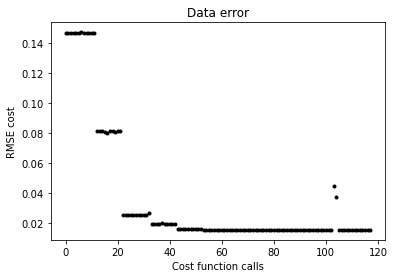

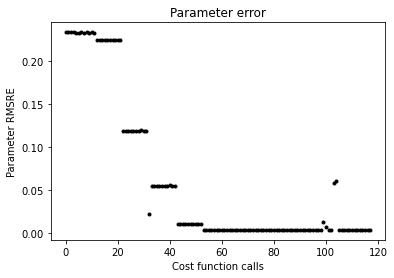

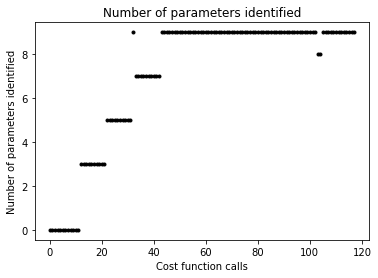

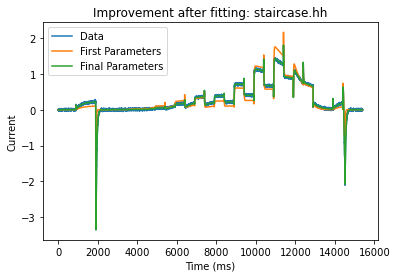

Fitted parameters are:
[2.24099444e-04 7.01719355e-02 3.46190030e-05 5.45938501e-02
 8.71829833e-02 8.88823401e-03 5.13966925e-03 3.15973435e-02
 1.52658244e-01]


In [13]:
app = ionbench.optimisers.scipy_optimisers.lm_scipy.get_approach()
app.apply(hh)
hh.reset() #Don't worry about this yet
out = ionbench.optimisers.scipy_optimisers.lm_scipy.run(hh)
print('Fitted parameters are:')
print(out)

Once the optimisation is complete, the optimiser calls `hh.evaluate(parameters)` with the fitted parameters. This function prints the performance metrics for this final point as well as the performance metrics when the optimiser converged. It then plots the performance metrics over time and the model output for the first parameters, the final/fitted parameters, and the data.

These plots can be disabled by setting `hh.plotter = False`.

## Tracker
Each benchmarker stores a __Tracker__ object which calculates and stores the performance metrics over time as well as figuring out when the optimiser converged. You shouldn't normally need to interact with this __Tracker__ object but you may wish to save the information from a __Tracker__ and store it to analyse later, for example if you are running an optimiser on a HPC and can't view the figures. You can use the __Tracker__'s `.save()` and `.load()` methods to do exactly that. 

You may have noticed the line `hh.reset()` in the previous code cell. This resets the __Tracker__ object, since otherwise all the times we called the cost function would have been included in the plots.

In [14]:
filename = 'temporary_tracker_file.pickle'
print('Number of times the model has been solved: ')
print(hh.tracker.solveCount)
hh.tracker.save(filename)
print('Number of model solves after reset:')
hh.reset()
print(hh.tracker.solveCount)
print('Number of model solves after load:')
hh.tracker.load(filename)
print(hh.tracker.solveCount)

Number of times the model has been solved: 
117
Number of model solves after reset:
0
Number of model solves after load:
117


In [15]:
#Remove temporary file
os.remove(filename)

## Multistart
It might be useful to start an optimisation multiple times. This can be done with the multistart function. It takes inputs of an optimisers `.run` function, a benchmarker, a list of initial parameters, and a filename to use for saving the tracker information.

Additional keyword arguements, such as hyperparameters to pass into the optimiser can also be passed into the multistart function. 

The filename will be automatically appended with `'_run%i.pickle'` where `%i` is the index for which of the initial parameters was used for the optimisation.

In addition to saving the tracker data and printing the evaluate output (which is done whenever an optimiser is called), the multistart function will also print the fitted parameters for each optimisation.

`xtol` termination condition is satisfied.
Function evaluations 87, initial cost 3.8836e+02, final cost 1.8651e+00, first-order optimality 1.51e+02.

===    Evaluating Final Parameters    ===

Number of cost evaluations:      108
Final cost:                      0.015564
Parameter RMSRE:                 0.003528
Number of identified parameters: 9
Total number of parameters:      9
Model solves until convergence:  97
Cost at convergence:             0.015564
Parameter RMSRE at convergence:  0.003530



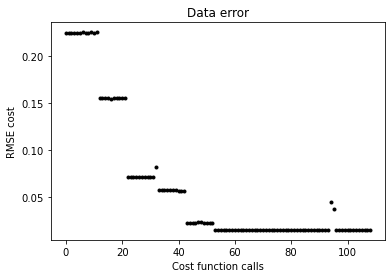

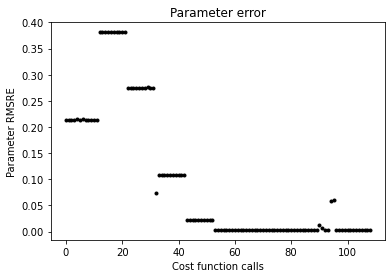

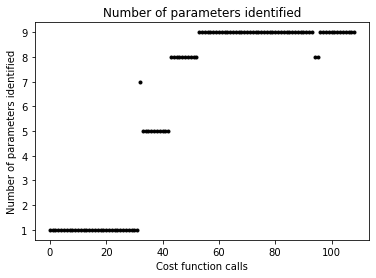

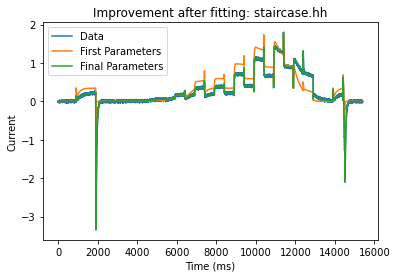

[2.24098812e-04 7.01729287e-02 3.46187853e-05 5.45938351e-02
 8.71894042e-02 8.88894751e-03 5.14014521e-03 3.15967447e-02
 1.52655174e-01]
`xtol` termination condition is satisfied.
Function evaluations 98, initial cost 3.7795e+02, final cost 1.8651e+00, first-order optimality 1.57e+02.

===    Evaluating Final Parameters    ===

Number of cost evaluations:      119
Final cost:                      0.015564
Parameter RMSRE:                 0.003528
Number of identified parameters: 9
Total number of parameters:      9
Model solves until convergence:  108
Cost at convergence:             0.015564
Parameter RMSRE at convergence:  0.003530



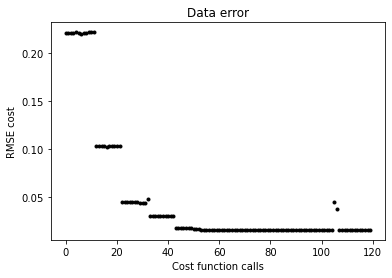

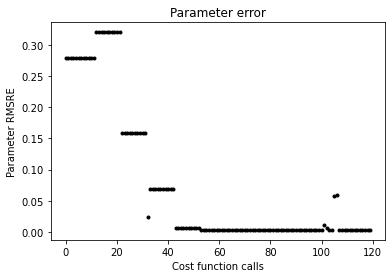

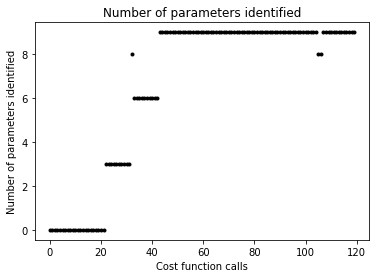

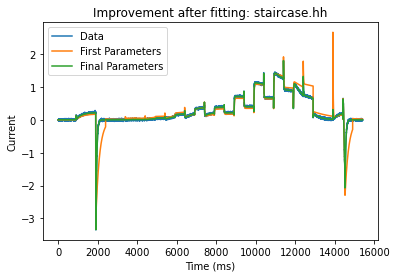

[2.24099161e-04 7.01722735e-02 3.46189449e-05 5.45938205e-02
 8.71892977e-02 8.88898771e-03 5.14008779e-03 3.15966379e-02
 1.52656850e-01]
`xtol` termination condition is satisfied.
Function evaluations 130, initial cost 2.3738e+02, final cost 1.8651e+00, first-order optimality 1.45e+02.

===    Evaluating Final Parameters    ===

Number of cost evaluations:      151
Final cost:                      0.015564
Parameter RMSRE:                 0.003510
Number of identified parameters: 9
Total number of parameters:      9
Model solves until convergence:  140
Cost at convergence:             0.015564
Parameter RMSRE at convergence:  0.003512



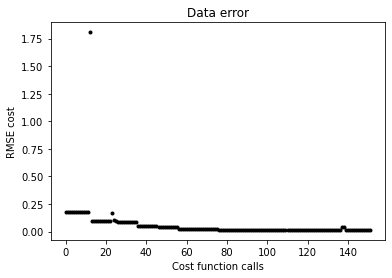

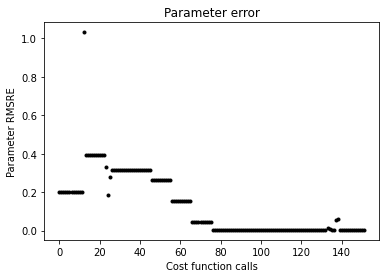

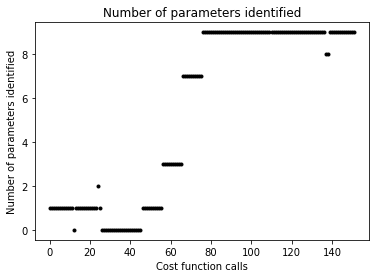

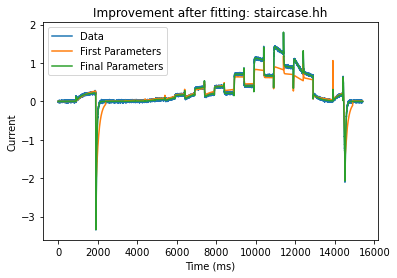

[2.24106508e-04 7.01689108e-02 3.46186847e-05 5.45938820e-02
 8.71929340e-02 8.88912123e-03 5.14018241e-03 3.15961959e-02
 1.52660778e-01]


In [16]:
opt = ionbench.optimisers.scipy_optimisers.lm_scipy.run
hh.reset()
initParams = hh.sample(3)
filename = 'temporary_tracker_files'
ionbench.multistart(opt, hh, initParams, filename)

In [17]:
os.remove(filename+'_run0.pickle')
os.remove(filename+'_run1.pickle')
os.remove(filename+'_run2.pickle')